# Import Libariers and Dataset Loading

In [1]:
!pip install --upgrade supervision
!pip install ultralytics
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from shapely.geometry import Polygon
import supervision as sv
import random
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from tqdm import tqdm
import yaml
import cv2
from ultralytics import YOLO
import time 
from shapely.geometry import box

images_path = '/kaggle/input/srip-2025/image_chips_native-20250212T103727Z-001/image_chips_native'
labels_path = '/kaggle/input/srip-2025/labels-20250212T103318Z-001/labels/labels_native/'
label_files = glob.glob(os.path.join(labels_path, '*.txt'))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.1/922.1 kB 15.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Data Exploration and Understanding

#### 1. Dataset statistics 


In [2]:
import os
import glob
import shutil

# -------------------------------
# Step 0: Copy the labels dataset to a writable working directory
# -------------------------------
src_labels_path = '/kaggle/input/srip-2025/labels-20250212T103318Z-001/labels/labels_native/'
dst_labels_path = '/kaggle/working/srip_labels/labels_native/'

# Create destination directory if it doesn't exist
os.makedirs(dst_labels_path, exist_ok=True)

# Copy all .txt files from the source to destination
src_label_files = glob.glob(os.path.join(src_labels_path, '*.txt'))
for file in src_label_files:
    shutil.copy(file, dst_labels_path)
    
print(f"Copied {len(src_label_files)} label files to {dst_labels_path}")

# -------------------------------
# Step 1: Count initial class distribution in the working copy
# -------------------------------
label_files = glob.glob(os.path.join(dst_labels_path, '*.txt'))

total_instances = 0
class_count = {}

for label_file in label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
        total_instances += len(lines)
        for line in lines:
            cls = line.split()[0]
            class_count[cls] = class_count.get(cls, 0) + 1

class_count = dict(sorted(class_count.items()))
print("Initial Distribution:")
print(f"Total instances: {total_instances}")
print(f"Number of unique classes: {len(class_count)}")
print("Class-wise distribution:")
for cls, count in class_count.items():
    print(f"    Class {cls}: {count}")

for label_file in label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
    
    unique_lines = set()
    new_lines = []
    
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue
        
        if parts[0] in ['1', '2']:
            parts[0] = '0'
        
        new_line = ' '.join(parts)
        
        if new_line not in unique_lines:
            unique_lines.add(new_line)
            new_lines.append(new_line)
    
    with open(label_file, 'w') as f:
        for line in new_lines:
            f.write(line + "\n")

new_class_count = {}
updated_total_instances = 0

for label_file in label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
        updated_total_instances += len(lines)
        for line in lines:
            cls = line.split()[0]
            new_class_count[cls] = new_class_count.get(cls, 0) + 1

new_class_count = dict(sorted(new_class_count.items()))
print("\nUpdated class-wise distribution:")
for cls, count in new_class_count.items():
    print(f"    Class {cls}: {count}")

print(f"\nTotal updated instances: {updated_total_instances}")


Copied 2542 label files to /kaggle/working/srip_labels/labels_native/
Initial Distribution:
Total instances: 29625
Number of unique classes: 3
Class-wise distribution:
    Class 0: 29267
    Class 1: 130
    Class 2: 228

Updated class-wise distribution:
    Class 0: 29625

Total updated instances: 29625


In [3]:
import os
import glob
import shutil

# Define source images directory
src_images_path = '/kaggle/input/srip-2025/image_chips_native-20250212T103727Z-001/image_chips_native'

# Define working labels directory (already copied in previous steps)
working_labels_path = '/kaggle/working/srip_labels/labels_native/'

# Define destination working images directory
dst_images_path = '/kaggle/working/srip_images/'
os.makedirs(dst_images_path, exist_ok=True)

# Get a list of all label files in the working labels directory
label_files = glob.glob(os.path.join(working_labels_path, '*.txt'))

# For each label file, derive the corresponding image filename and copy it if exists.
copied_images = 0
for label_file in label_files:
    # Get the base name of the label file (e.g., "solarpanels_native_2__x0_461_y0_11037_dxdy_416.txt")
    base_name = os.path.basename(label_file)
    # Change the extension from .txt to .tif (assuming images have .tif extension)
    image_filename = base_name.replace('.txt', '.tif')
    src_image_file = os.path.join(src_images_path, image_filename)
    
    # If the image exists in the source, copy it to the working images directory.
    if os.path.exists(src_image_file):
        shutil.copy(src_image_file, dst_images_path)
        copied_images += 1

print(f"Copied {copied_images} images to {dst_images_path}")

Copied 2542 images to /kaggle/working/srip_images/


In [4]:
import os
import glob
import pandas as pd
from tqdm import tqdm

# Define paths
labels_path = "/kaggle/working/srip_labels/labels_native/"  # Updated path where label files are stored

# Get all label files in the working directory
label_files = glob.glob(os.path.join(working_labels_path, "*.txt"))

def count_labels_in_file(label_file):
    """
    Count the number of solar panel instances in a label file.
    Each non-empty line represents one solar panel.
    """
    try:
        with open(label_file, 'r') as f:
            lines = f.readlines()
            return len([line for line in lines if line.strip()])
    except Exception as e:
        print(f"Error reading file {label_file}: {e}")
        return 0

# Process label files and collect data
data = []
for file in tqdm(label_files, desc="Processing label files"):
    # Derive the corresponding image name (assuming .tif extension)
    image_name = os.path.basename(file).replace(".txt", ".tif")
    label_count = count_labels_in_file(file)
    data.append({"Image": image_name, "Label_Count": label_count})

# Create a DataFrame from the collected data
df_labels = pd.DataFrame(data)

# Calculate total number of solar panel instances
total_labels = df_labels["Label_Count"].sum()

# Calculate the distribution of label counts per image
value_counts = df_labels["Label_Count"].value_counts().sort_index()

# Calculate summary statistics
summary_stats = {
    "Total Images": len(df_labels),
    "Total Solar Panels": total_labels,
    "Average Panels per Image": total_labels / len(df_labels) if len(df_labels) > 0 else 0,
    "Max Panels in Single Image": df_labels["Label_Count"].max() if not df_labels.empty else 0,
    "Min Panels in Single Image": df_labels["Label_Count"].min() if not df_labels.empty else 0,
    "Images with No Panels": (df_labels["Label_Count"] == 0).sum()
}

# Sort DataFrame by label count in descending order for detailed view
detailed_counts = df_labels.sort_values("Label_Count", ascending=False)

# Display summary statistics
print("\nSummary Statistics:")
for key, value in summary_stats.items():
    print(f"{key}: {value}")

# Display first few rows of detailed counts
print("\nDetailed Label Counts:")
print(detailed_counts.head())


Processing label files: 100%|██████████| 2542/2542 [00:00<00:00, 36878.93it/s]


Summary Statistics:
Total Images: 2542
Total Solar Panels: 29625
Average Panels per Image: 11.654209284028324
Max Panels in Single Image: 78
Min Panels in Single Image: 1
Images with No Panels: 0

Detailed Label Counts:
                                                  Image  Label_Count
518   solarpanels_native_2__x0_714_y0_10614_dxdy_416...           78
127   solarpanels_native_2__x0_708_y0_10623_dxdy_416...           77
900   solarpanels_native_2__x0_739_y0_10553_dxdy_416...           77
2289  solarpanels_native_2__x0_691_y0_10632_dxdy_416...           76
565   solarpanels_native_2__x0_751_y0_10547_dxdy_416...           76


a. How many instances of solar panels are present in the dataset?
b. Compute and show the value counts of labels per image. E.g., X images have 0 labels, Y images have 1 label, … and so on.

In [5]:
print("\nDataset Summary Statistics:")
print("-" * 50)
for metric, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.2f}")
    else:
        print(f"{metric}: {value}")

print("\nDistribution of Panels per Image:")
print("-" * 50)
print(value_counts.to_string())

print("\nTop 5 Images with Most Panels:")
print("-" * 50)
print(detailed_counts.head().to_string(index=False))


Dataset Summary Statistics:
--------------------------------------------------
Total Images: 2542
Total Solar Panels: 29625
Average Panels per Image: 11.65
Max Panels in Single Image: 78
Min Panels in Single Image: 1
Images with No Panels: 0

Distribution of Panels per Image:
--------------------------------------------------
Label_Count
1      81
2     167
3     221
4     218
5     217
6     189
7     170
8     184
9     169
10    121
11     97
12     84
13     69
14     49
15     46
16     41
17     36
18     25
19     29
20     14
21      4
22      1
23      4
24      2
25      4
26      3
27      5
28      5
29     15
30     20
31      8
32      7
33     13
34     19
35     10
36      6
37     17
38     13
39      6
40      9
41     10
42     12
43     11
44      4
45      2
46      5
47      9
48      3
49      5
50      6
51      9
52     16
53      4
54      6
55      1
56      1
58      3
59      2
60      2
61      1
62      6
63      3
64      1
65      3
66      4
67      1

#### 2.  Calculate the statistics of the area of solar panels in meters (Read label readme carefully for this question)

a.What method was used to compute the area (in meters) for a single instance?
b.What is the mean area and standard deviation?
c.Plot the histogram of areas. What do you observe?

Using fixed image dimensions: 416x416 pixels


Calculating areas: 100%|██████████| 2542/2542 [00:00<00:00, 21975.32it/s]


Method Used to Compute Area:
--------------------------------------------------
For each solar panel instance:
1. Extract normalized x_width and y_width from label file.
2. Convert to pixels: width_pixels = normalized_width * image_width
3. Convert to meters: width_meters = width_pixels * 0.31
4. Area = x_width_meters * y_width_meters (in square meters)

Area Statistics:
--------------------------------------------------
Total Instances: 29625
Mean Area: 191.52 square meters
Standard Deviation: 630.70 square meters
Median Area: 91.68 square meters
Minimum Area: 1.06 square meters
Maximum Area: 12177.41 square meters


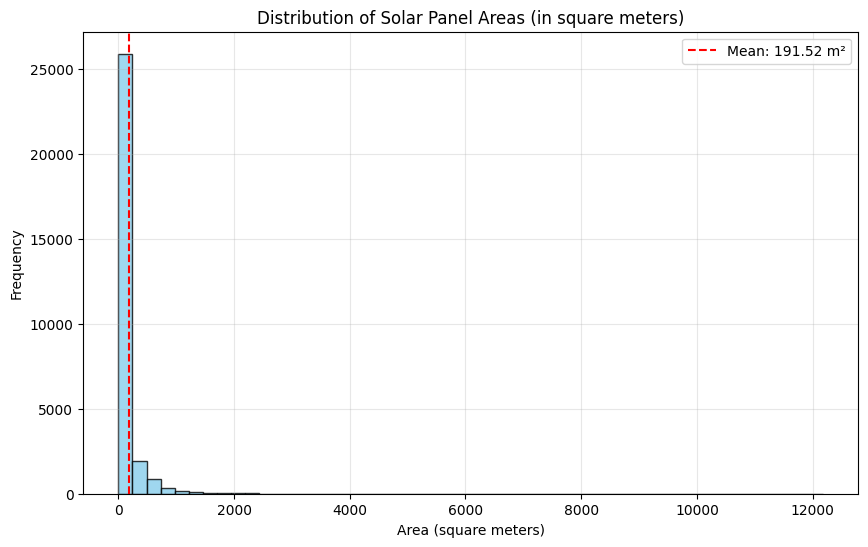


Observations from Histogram:
--------------------------------------------------
- The distribution peaks around 191.52 square meters.
- Spread is indicated by std dev of 630.70; higher values suggest variability.
- Check for skewness: right skew may indicate a few large panels, left skew small ones.
- Multiple peaks could suggest different panel sizes in the dataset.


In [6]:
PIXEL_SIZE = 0.31  # Meters per pixel, verify with your dataset documentation

# Function to calculate area in square meters from a single label line
def calculate_area_from_line(line, img_width, img_height):
    parts = line.strip().split()
    if len(parts) != 5:
        return None  # Skip malformed lines
    try:
        # Extract normalized width and height
        x_width_norm = float(parts[3])
        y_width_norm = float(parts[4])

        # Convert normalized to pixel dimensions
        x_width_pixels = x_width_norm * img_width
        y_width_pixels = y_width_norm * img_height

        # Convert pixel dimensions to meters
        x_width_meters = x_width_pixels * PIXEL_SIZE
        y_width_meters = y_width_pixels * PIXEL_SIZE

        # Calculate area in square meters
        return x_width_meters * y_width_meters
    except (ValueError, IndexError):
        return None  # Return None for invalid data

# Collect areas for all solar panel instances
areas = []
label_files = glob.glob(os.path.join(labels_path, '*.txt'))

# Assuming all images have the same size, get dimensions from one image
sample_image_path = os.path.join(images_path, os.listdir(images_path)[0])
with Image.open(sample_image_path) as img:
    img_width, img_height = img.size
print(f"Using fixed image dimensions: {img_width}x{img_height} pixels")

# Process all label files
for label_file in tqdm(label_files, desc="Calculating areas"):
    try:
        # Read label file (no need to open the image)
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.strip():  # Skip empty lines
                    area = calculate_area_from_line(line, img_width, img_height)
                    if area is not None:
                        areas.append(area)
    except Exception as e:
        print(f"Error processing {label_file}: {e}")

# Convert areas to numpy array for calculations
areas = np.array(areas)

# Calculate statistics
total_instances = len(areas)
mean_area = np.mean(areas) if total_instances > 0 else 0
std_area = np.std(areas) if total_instances > 0 else 0
median_area = np.median(areas) if total_instances > 0 else 0
min_area = np.min(areas) if total_instances > 0 else 0
max_area = np.max(areas) if total_instances > 0 else 0

# Display method and statistics
print("\nMethod Used to Compute Area:")
print("-" * 50)
print("For each solar panel instance:")
print("1. Extract normalized x_width and y_width from label file.")
print("2. Convert to pixels: width_pixels = normalized_width * image_width")
print(f"3. Convert to meters: width_meters = width_pixels * {PIXEL_SIZE}")
print("4. Area = x_width_meters * y_width_meters (in square meters)")

print("\nArea Statistics:")
print("-" * 50)
print(f"Total Instances: {total_instances}")
print(f"Mean Area: {mean_area:.2f} square meters")
print(f"Standard Deviation: {std_area:.2f} square meters")
print(f"Median Area: {median_area:.2f} square meters")
print(f"Minimum Area: {min_area:.2f} square meters")
print(f"Maximum Area: {max_area:.2f} square meters")

# Plot histogram of areas
plt.figure(figsize=(10, 6))
plt.hist(areas, bins = 50, color='skyblue', edgecolor='black', alpha=0.8)
plt.title('Distribution of Solar Panel Areas (in square meters)')
plt.xlabel('Area (square meters)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.axvline(mean_area, color='r', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_area:.2f} m²')
plt.legend()
plt.show()

# Observations
print("\nObservations from Histogram:")
print("-" * 50)
if total_instances > 0:
    print(f"- The distribution peaks around {mean_area:.2f} square meters.")
    print(f"- Spread is indicated by std dev of {std_area:.2f}; higher values suggest variability.")
    print("- Check for skewness: right skew may indicate a few large panels, left skew small ones.")
    print("- Multiple peaks could suggest different panel sizes in the dataset.")
else:
    print("No valid areas calculated; check data integrity.")

# Implementing the Fundamental Functions


#### 1. Write a function to compute IoU (Intersection over Union) https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/ between two axis-aligned bounding boxes specified in the Ultralytics YOLO format. You MUST use the shapely library [https://pypi.org/project/shapely/] and its functionalities to write your function. Show that your function provides the same or similar answer as IoU computed using `supervision` library 

In [7]:
boxA = [35, 51,196, 110]
boxB = [25, 60,180, 120]

xA = max(boxA[0], boxB[0])
yA = max(boxA[1], boxB[1])
xB = min(boxA[2], boxB[2])
yB = min(boxA[3], boxB[3])

print(xA,yA,xB,yB)

interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

iou = interArea / float(boxAArea + boxBArea - interArea)

print(iou)

35 60 180 110
0.6315521628498728


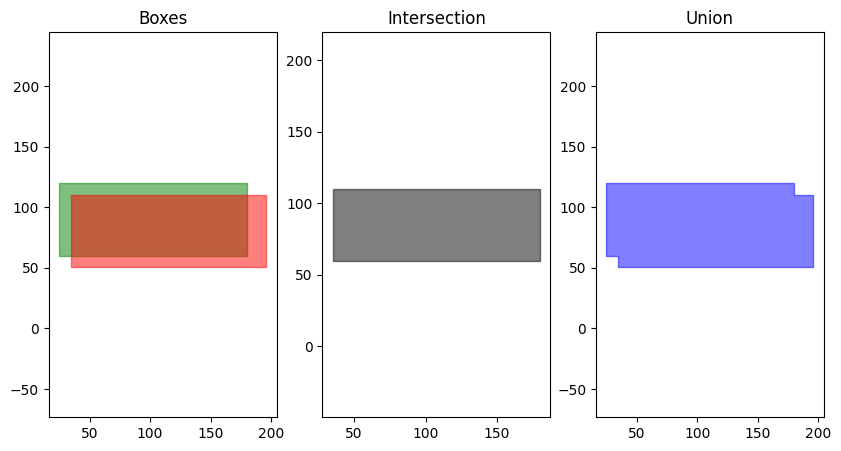

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from shapely.geometry import box

def plot_polygon(shapely_box, color='b'):
    if shapely_box is None or shapely_box.is_empty:
        return
    try:
        # Get the exterior coordinates of the shapely box
        x, y = shapely_box.exterior.xy
        vertices = list(zip(x, y))
        poly = Polygon(vertices, closed=True, fill=True, color=color, alpha=0.5)
        plt.gca().add_patch(poly)
        plt.axis('equal')  # Equal aspect ratio
    except Exception as e:
        print(f"Error plotting polygon: {e}")

# Create boxes using shapely.geometry.box
# Note: shapely.box uses (minx, miny, maxx, maxy)
bA = box(35, 51, 196, 110)
bB = box(25, 60, 180, 120)

plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.title("Boxes")
plot_polygon(bB, color='g')
plot_polygon(bA, color='r')

plt.subplot(1,3,2)
plt.title("Intersection")
interArea = bA.intersection(bB)
plot_polygon(interArea, color='k')

plt.subplot(1,3,3)
plt.title("Union")
union = bA.union(bB)
plot_polygon(union, color='b')

plt.show()

In [9]:

def compIou(bA,bB):
  return bA.intersection(bB).area / bA.union(bB).area

bA = box(35, 51,196, 110)
bB = box(25, 60,180, 120)

compIou(bA,bB)

0.62775997921898

In [10]:
bA = [[35, 51,196, 110]]
bB = [[25, 60,180, 120]]
bA = np.asarray(bA)
bB = np.asarray(bB)
sv.box_iou_batch(bA,bB)

array([[    0.62776]])

#### 2. Write a function to compute Average Precision (AP) 

In [11]:
def getPreRec(gx,gy,px,py):
    IOU=[]
    for i in range(0,10):
        bA = box(gx[i],gy[i],gx[i]+20,gy[i]+20)
        bB = box(px[i],py[i],px[i]+20,py[i]+20)
        iou = bA.intersection(bB).area / bA.union(bB).area
        IOU.append(iou)

    tpfp = ["TP" if score >=0.5 else "FP" for score in IOU]

    sc = 0
    accTP = []
    for i in range(0,10):
        if tpfp[i]=="TP":
            sc+=1
        accTP.append(sc)

    sc =0
    accFP = []
    for i in range(0,10):
        if tpfp[i]=="FP":
            sc+=1
        accFP.append(sc)

    groundTruths = 10
    precision = []
    recall = []

    for i in range(0,10):
        precision.append(accTP[i]/(accTP[i]+accFP[i]))
        recall.append(accTP[i]/groundTruths)

    return precision,recall

a. Use Pascal VOC 11 point interpolation method to implement the function 

In [12]:
def point11(precision,recall):
    su = 0
    r = np.linspace(0,1,11)

    for i in r:
        valid = [p for p,r in zip(precision,recall) if r>=i]
        if valid:
            su+=max(valid)
        else:
            su+=0
    return su/11

b. Use COCO 101-point interpolation method to implement the function.

In [13]:
def point101(precision,recall):
    su = 0
    r = np.linspace(0,1,101)

    for i in r:
        valid = [p for p,r in zip(precision,recall) if r>=i]
        if valid:
            su+=max(valid)
        else:
            su+=0
    return su/101     

c. Use Area under Precision-Recall Curve (AP) method to implement the function 

In [14]:
def AUC(precision,recall,length):
    s=0
    for i in range(1,length):
        width = recall[i]-recall[i-1]
        height = max(precision[i],precision[i-1])
        s += width*height
    return s

d.Randomly generate 10 images of size 100x100. Randomly generate 10 ground truth boxes of size 20x20 and 10 predicted boxes of size 20x20 in each image. Assume there is only one class of objects. Compare the AP50 (Average Precision at IoU 0.5) computed by 3 of your methods.

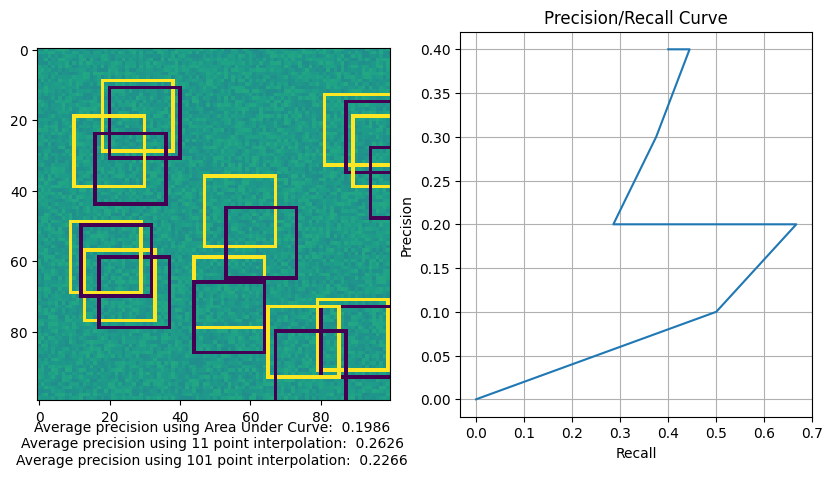

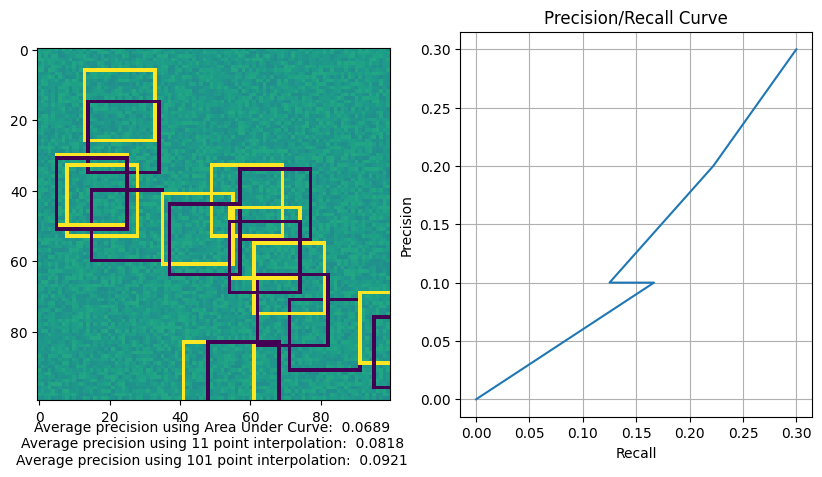

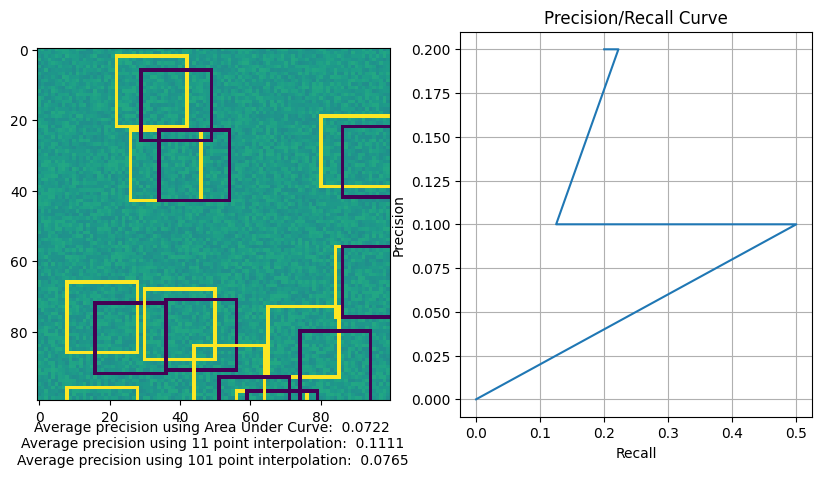

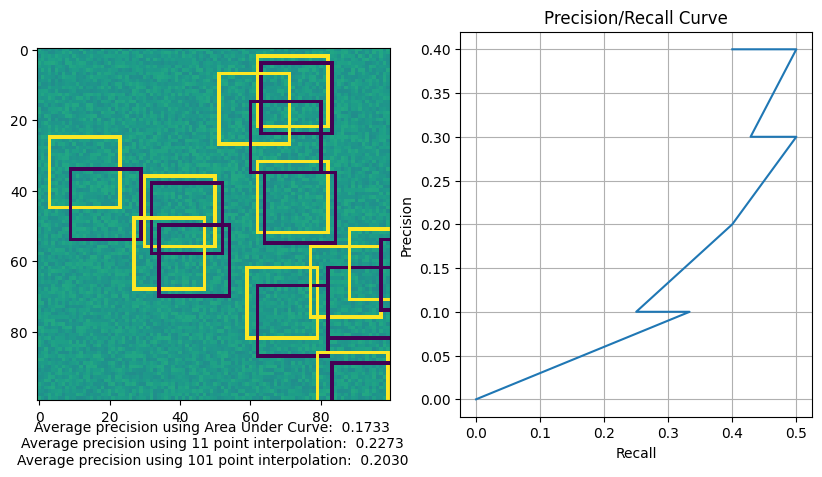

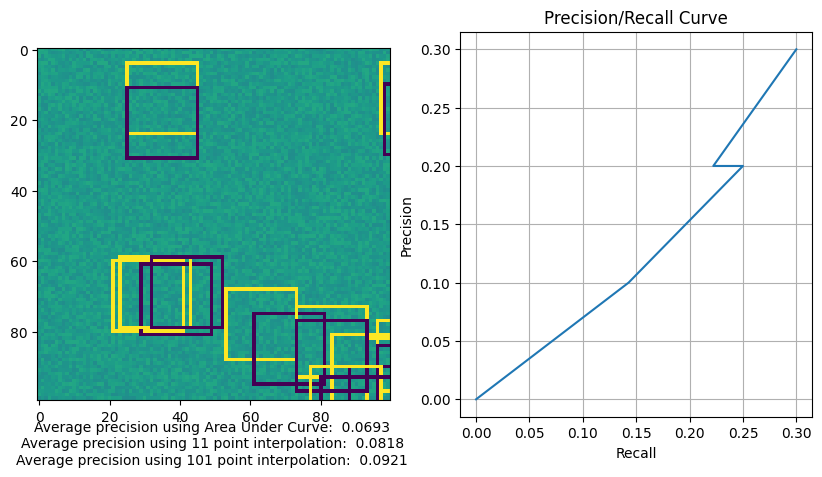

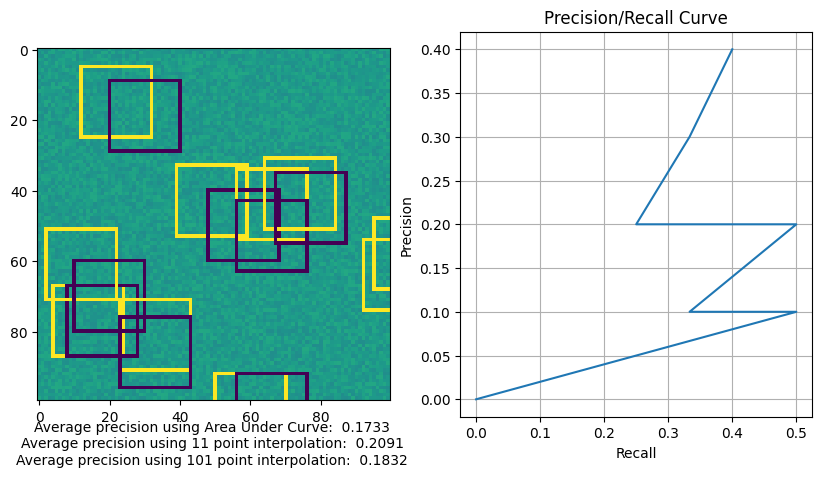

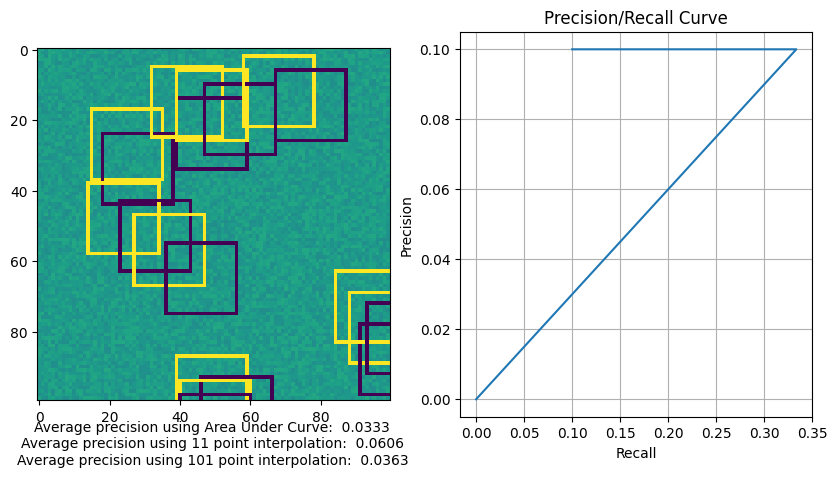

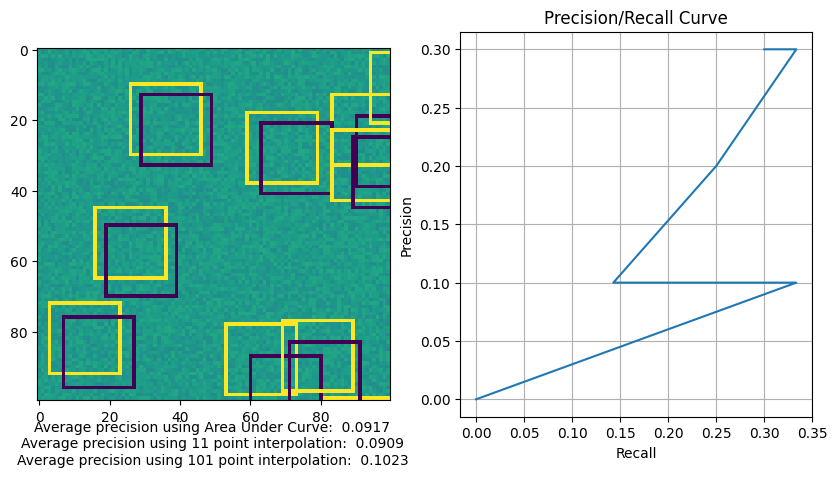

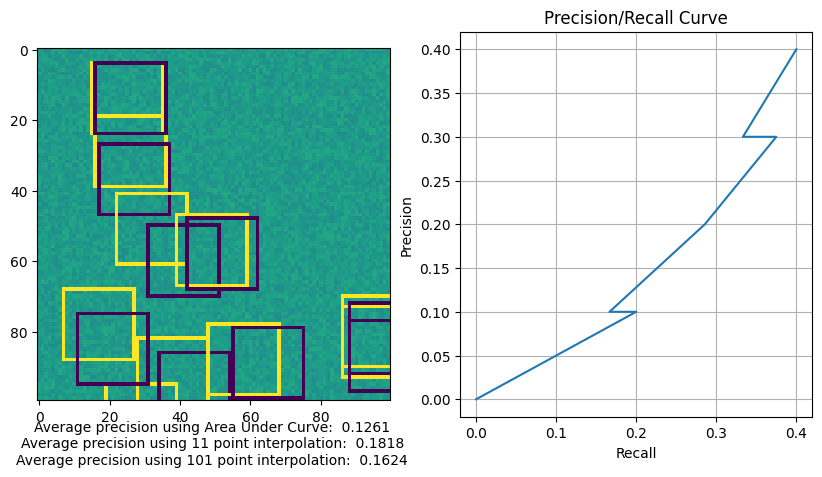

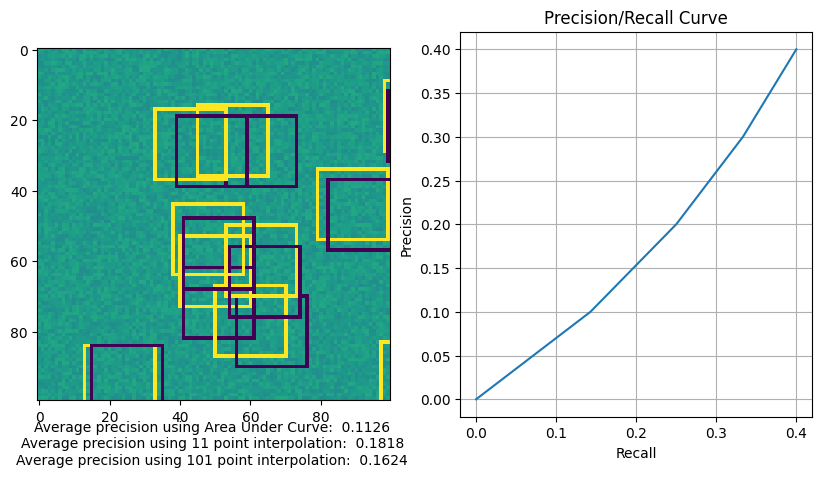

In [15]:
imgs = np.random.randint(125,155,size=(10,100,100)).astype(float)


# plt.figure(figsize=(20,10))
for i in range(0,10):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)


    gx = np.random.randint(0,100,size=(10))
    gy = np.random.randint(0,100,size=(10))

    px = np.random.randint(gx,gx+10,size=(10))
    py = np.random.randint(gy,gy+10,size=(10))

    precision,recall = getPreRec(gx,gy,px,py)



    for j in range(0,10):
        img = cv2.rectangle(imgs[i],(gx[j],gy[j]),(gx[j]+20,gy[j]+20),(255,0,0),1)
        img = cv2.rectangle(imgs[i],(px[j],py[j]),(px[j]+20,py[j]+20),(0,255,0),1)

    plt.imshow(img)

    plt.subplot(1,2,2)


    plt.plot(precision,recall)
    plt.grid()
    plt.title("Precision/Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

    plt.figtext(
        0.3, 0.02,
        f"Average precision using Area Under Curve:  {AUC(precision,recall,10):.4f}\nAverage precision using 11 point interpolation:  {point11(precision,recall):.4f}\nAverage precision using 101 point interpolation:  {point101(precision,recall):.4f}",
        wrap=True, horizontalalignment='center', fontsize=10 )

     

# Model building and evaluation 



#### 1.Split the data into 80-20 train-test split. Use 10% of training data as validation.
Use any model from Ultralytics like YOLO to train the object detection model. Show that validation loss is converged. 

In [16]:
import os

# Define the paths to the directories
images_path = '/kaggle/working/srip_images'
labels_path = '/kaggle/working/srip_labels/labels_native'

# Check and count files in srip_images directory
if not os.path.isdir(images_path):
    print(f"Error: {images_path} is not a directory or does not exist.")
else:
    images_files = [f for f in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, f))]
    print(f"Number of files in {images_path}: {len(images_files)}")

# Check and count files in srip_labels directory
if not os.path.isdir(labels_path):
    print(f"Error: {labels_path} is not a directory or does not exist.")
else:
    labels_files = [f for f in os.listdir(labels_path) if os.path.isfile(os.path.join(labels_path, f))]
    print(f"Number of files in {labels_path}: {len(labels_files)}")

Number of files in /kaggle/working/srip_images: 2542
Number of files in /kaggle/working/srip_labels/labels_native: 2542


In [17]:
!pip install pyyaml 
import os
import glob
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import yaml

images_path = '/kaggle/working/srip_images'
labels_path = '/kaggle/working/srip_labels/labels_native'

# Base directory for the dataset splits
base_dir = '/kaggle/working/srip_dataset_split'
train_img_dir = os.path.join(base_dir, 'train', 'images')
train_lbl_dir = os.path.join(base_dir, 'train', 'labels')
val_img_dir   = os.path.join(base_dir, 'val', 'images')
val_lbl_dir   = os.path.join(base_dir, 'val', 'labels')
test_img_dir  = os.path.join(base_dir, 'test', 'images')
test_lbl_dir  = os.path.join(base_dir, 'test', 'labels')

# Create directories if they don't already exist
for directory in [train_img_dir, train_lbl_dir, val_img_dir, val_lbl_dir, test_img_dir, test_lbl_dir]:
    os.makedirs(directory, exist_ok=True)

# Check if source directories exist
if not os.path.exists(images_path):
    raise FileNotFoundError(f"Images directory not found: {images_path}")
if not os.path.exists(labels_path):
    raise FileNotFoundError(f"Labels directory not found: {labels_path}")

# List all image files in the original images directory
image_files = glob.glob(os.path.join(images_path, '*'))  # Adjust pattern if needed (e.g., '*.tif')
if not image_files:
    raise ValueError(f"No image files found in {images_path}")

# Split into 80% train and 20% test
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Further split training files into 90% train and 10% validation
train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

def copy_files(file_list, dest_img_dir, dest_lbl_dir):
    """
    Copy image files and their corresponding label files into destination directories.
    Assumes label files have '.txt' extension matching image basenames.
    """
    missing_labels = 0
    for file in tqdm(file_list, desc=f"Copying files to {dest_img_dir}"):
        # Copy the image file
        shutil.copy(file, dest_img_dir)
        
        # Derive the corresponding label file (assuming image extension like '.tif', '.jpg', etc.)
        base_name = os.path.splitext(os.path.basename(file))[0]  # Remove extension
        label_file = os.path.join(labels_path, base_name + '.txt')
        if os.path.exists(label_file):
            shutil.copy(label_file, dest_lbl_dir)
        else:
            missing_labels += 1
            print(f"Warning: Label file not found for {file}")
    if missing_labels > 0:
        print(f"Total missing label files: {missing_labels}")

# Copy files into their respective directories
copy_files(train_files, train_img_dir, train_lbl_dir)
copy_files(val_files, val_img_dir, val_lbl_dir)
copy_files(test_files, test_img_dir, test_lbl_dir)

print("Dataset splitting and copying completed!")

# Define the YAML configuration dictionary using the image directories
data_yaml = {
    "train": train_img_dir,  # Path to training images
    "val": val_img_dir,      # Path to validation images
    "test": test_img_dir,    # Path to test images (optional for evaluation)
    "nc": 1,                 # Number of classes
    "names": ["solar_panel"] # List of class names
}

# Specify the path where the YAML file will be saved
yaml_path = os.path.join(base_dir, "data.yaml")

# Write the YAML file
with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print("YAML configuration file created at:", yaml_path)

# Verify the created structure
for split in ['train', 'val', 'test']:
    img_dir = os.path.join(base_dir, split, 'images')
    lbl_dir = os.path.join(base_dir, split, 'labels')
    print(f"{split} set: {len(os.listdir(img_dir))} images, {len(os.listdir(lbl_dir))} labels")

Copying files to /kaggle/working/srip_dataset_split/train/images: 100%|██████████| 1829/1829 [00:01<00:00, 1638.23it/s]
Copying files to /kaggle/working/srip_dataset_split/val/images: 100%|██████████| 204/204 [00:00<00:00, 1677.31it/s]
Copying files to /kaggle/working/srip_dataset_split/test/images: 100%|██████████| 509/509 [00:00<00:00, 1559.60it/s]

Dataset splitting and copying completed!
YAML configuration file created at: /kaggle/working/srip_dataset_split/data.yaml
train set: 1829 images, 1829 labels
val set: 204 images, 204 labels
test set: 509 images, 509 labels


In [18]:
import os

# Define the base directory
base_dir = '/kaggle/working/srip_dataset_split'

# Define the set names
sets = ['train', 'val', 'test']

# Loop through each set
for set_name in sets:
    # Construct the image and label directory paths
    img_dir = os.path.join(base_dir, set_name, 'images')
    lbl_dir = os.path.join(base_dir, set_name, 'labels')
    
    # Check and count images
    if not os.path.isdir(img_dir):
        print(f"Error: {img_dir} is not a directory or does not exist.")
        num_images = 0
    else:
        images = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
        num_images = len(images)
    
    # Check and count labels
    if not os.path.isdir(lbl_dir):
        print(f"Error: {lbl_dir} is not a directory or does not exist.")
        num_labels = 0
    else:
        labels = [f for f in os.listdir(lbl_dir) if os.path.isfile(os.path.join(lbl_dir, f))]
        num_labels = len(labels)
    
    # Print the counts
    print(f"{set_name.capitalize()} set: {num_images} images, {num_labels} labels")
    
    # Check if the number of images and labels match
    if num_images != num_labels:
        print(f"Warning: Number of images ({num_images}) and labels ({num_labels}) do not match in {set_name} set.")

Train set: 1829 images, 1829 labels
Val set: 204 images, 204 labels
Test set: 509 images, 509 labels


In [19]:
# import yaml

# # Define the YAML configuration dictionary using the copied dataset directories
# data_yaml = {
#     "train": train_img_dir,  # Path to training images
#     "val":val_img_dir ,      # Path to validation images
#     "test":test_img_dir,    # (Optional) Path to test images
#     "nc": 1,                 # Number of classes
#     "names": ["solar_panel"] # List of class names
# }

# # Specify the path where the YAML file will be saved
# yaml_path = os.path.join(base_dir, "data.yaml")

# # Write the YAML file
# with open(yaml_path, "w") as f:
#     yaml.dump(data_yaml, f, sort_keys=False)

# print("YAML configuration file created at:", yaml_path)


In [20]:
!pip install ultralytics
from ultralytics import YOLO

# Load a COCO-pretrained YOLO11n model
model_run1 = YOLO("yolo11l.pt")
# Train the model with hyperparameters for Experiment 1:
# - 50 epochs, batch size 16, initial learning rate 0.01, image size 416x416
results_run1 = model_run1.train(
    data='/kaggle/working/srip_dataset_split/data.yaml',
    epochs=30,
    imgsz=416,
    batch=16,
    lr0=0.01,
    project='/kaggle/working/srip_training/yolov11l',
    name='run1'
)



100%|██████████| 49.0M/49.0M [00:00<00:00, 216MB/s]


Ultralytics 8.3.81 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/kaggle/working/srip_dataset_split/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=/kaggle/working/srip_training/yolov11l, name=run1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

100%|██████████| 755k/755k [00:00<00:00, 16.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    173824  ultralytics.nn.modules.block.C3k2            [128, 256, 2, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  2    691712  ultralytics.nn.modules.block.C3k2            [256, 512, 2, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.0MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/srip_dataset_split/train/labels... 1829 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1829/1829 [00:02<00:00, 740.19it/s]

train: New cache created: /kaggle/working/srip_dataset_split/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/srip_dataset_split/val/labels... 204 images, 0 backgrounds, 0 corrupt: 100%|██████████| 204/204 [00:00<00:00, 615.87it/s]

val: New cache created: /kaggle/working/srip_dataset_split/val/labels.cache


Plotting labels to /kaggle/working/srip_training/yolov11l/run1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to /kaggle/working/srip_training/yolov11l/run1
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.99G      1.674      1.358       1.29         45        416: 100%|██████████| 115/115 [00:41<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        204       2098      0.281      0.666      0.236      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.93G      1.568       1.08      1.207         99        416: 100%|██████████| 115/115 [00:39<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.55it/s]

                   all        204       2098          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      5.04G      1.489      1.021      1.186         49        416: 100%|██████████| 115/115 [00:39<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        204       2098       0.39      0.481       0.39      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.99G      1.462     0.9969      1.161         70        416: 100%|██████████| 115/115 [00:39<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        204       2098      0.577      0.611      0.555      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.94G      1.367     0.9098      1.113        151        416: 100%|██████████| 115/115 [00:40<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        204       2098       0.79      0.762      0.806      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.01G      1.354     0.8808      1.112         81        416: 100%|██████████| 115/115 [00:40<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        204       2098      0.742       0.69      0.723      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.95G      1.308     0.8403      1.088        129        416: 100%|██████████| 115/115 [00:40<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        204       2098      0.826      0.774      0.834      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.03G      1.222     0.7805       1.05        124        416: 100%|██████████| 115/115 [00:40<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        204       2098      0.786      0.753      0.814      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.93G       1.23     0.7975      1.061         59        416: 100%|██████████| 115/115 [00:40<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        204       2098      0.786      0.786       0.82      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.01G      1.204     0.7478       1.04         82        416: 100%|██████████| 115/115 [00:40<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        204       2098      0.863      0.783      0.846      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.94G      1.168     0.7326      1.031         46        416: 100%|██████████| 115/115 [00:40<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        204       2098      0.826      0.795      0.853      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.99G      1.154     0.7178      1.018         60        416: 100%|██████████| 115/115 [00:40<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        204       2098      0.868      0.801      0.865       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.94G       1.15     0.7112      1.018         85        416: 100%|██████████| 115/115 [00:40<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        204       2098      0.885      0.829      0.906      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.05G      1.115     0.6828      1.004         79        416: 100%|██████████| 115/115 [00:40<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        204       2098       0.83      0.798      0.848      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.96G      1.121     0.6809      1.011         68        416: 100%|██████████| 115/115 [00:40<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        204       2098      0.861      0.832      0.887      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         5G      1.084     0.6528     0.9887         51        416: 100%|██████████| 115/115 [00:40<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        204       2098      0.884      0.834      0.914      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.96G      1.063     0.6463     0.9832         84        416: 100%|██████████| 115/115 [00:40<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        204       2098      0.875      0.856      0.912      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.01G      1.045     0.6256      0.978         77        416: 100%|██████████| 115/115 [00:40<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        204       2098      0.878      0.836      0.902       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.97G      1.044     0.6151     0.9716        104        416: 100%|██████████| 115/115 [00:40<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        204       2098      0.881       0.84      0.914      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.01G      1.012     0.6032     0.9688         44        416: 100%|██████████| 115/115 [00:40<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]

                   all        204       2098      0.896      0.862      0.929      0.662


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.95G     0.9726     0.5765     0.9643         71        416: 100%|██████████| 115/115 [00:40<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        204       2098      0.893      0.844      0.923      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.04G      0.963     0.5567     0.9638         24        416: 100%|██████████| 115/115 [00:40<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        204       2098        0.9      0.882       0.94      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.94G     0.9301     0.5393     0.9529         32        416: 100%|██████████| 115/115 [00:40<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        204       2098       0.91      0.877      0.938      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.02G     0.9255     0.5326     0.9469         48        416: 100%|██████████| 115/115 [00:40<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        204       2098      0.919      0.877      0.946       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.93G     0.8969     0.5157     0.9345         35        416: 100%|██████████| 115/115 [00:40<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        204       2098      0.909      0.899      0.948      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         5G     0.8813     0.5021     0.9275         59        416: 100%|██████████| 115/115 [00:40<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        204       2098      0.926      0.894      0.952      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.97G     0.8633     0.4906     0.9297         80        416: 100%|██████████| 115/115 [00:40<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        204       2098      0.919      0.906      0.952      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.03G      0.851     0.4815     0.9208         79        416: 100%|██████████| 115/115 [00:40<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]

                   all        204       2098      0.905      0.901      0.951      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.95G     0.8317     0.4676     0.9149         42        416: 100%|██████████| 115/115 [00:40<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        204       2098      0.917      0.911      0.959      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.02G     0.8054     0.4573     0.9073         41        416: 100%|██████████| 115/115 [00:40<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        204       2098      0.926      0.924      0.964      0.736



30 epochs completed in 0.371 hours.
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run1/weights/last.pt, 51.2MB
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run1/weights/best.pt, 51.2MB

Validating /kaggle/working/srip_training/yolov11l/run1/weights/best.pt...
Ultralytics 8.3.81 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


                   all        204       2098      0.927      0.922      0.964      0.736


Speed: 0.1ms preprocess, 6.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/srip_training/yolov11l/run1


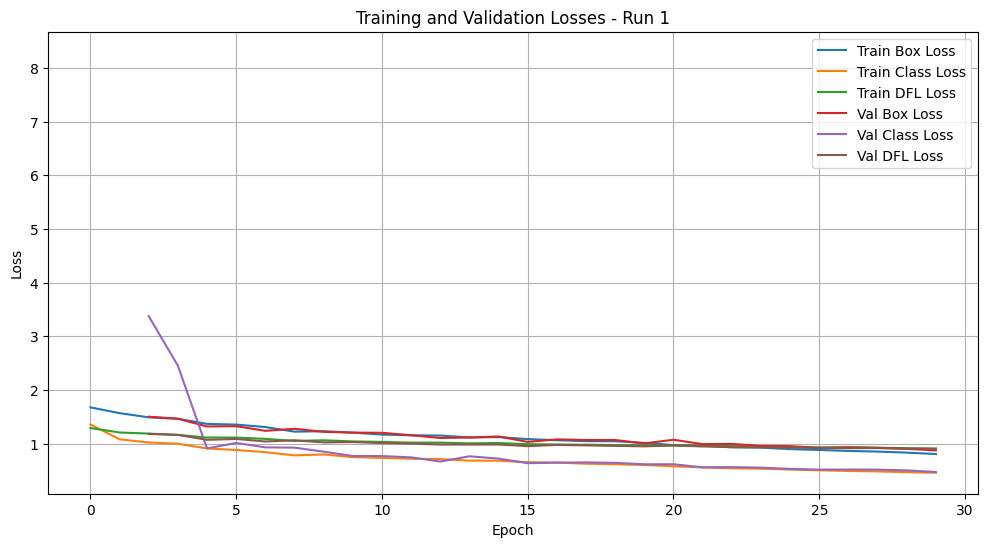

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training results from the CSV file
results_path = '/kaggle/working/srip_training/yolov11l/run1/results.csv'
results_df = pd.read_csv(results_path)

# Strip any whitespace from column names (common issue with Ultralytics CSV files)
results_df.columns = results_df.columns.str.strip()

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(results_df['train/box_loss'], label='Train Box Loss')
plt.plot(results_df['train/cls_loss'], label='Train Class Loss')
plt.plot(results_df['train/dfl_loss'], label='Train DFL Loss')  # Distribution Focal Loss (if available)
plt.plot(results_df['val/box_loss'], label='Val Box Loss')
plt.plot(results_df['val/cls_loss'], label='Val Class Loss')
plt.plot(results_df['val/dfl_loss'], label='Val DFL Loss')      # If available
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses - Run 1')
plt.legend()
plt.grid(True)
plt.show()

####  model 2

In [22]:
model_run2 = YOLO('yolo11l.pt')
results_run2 = model_run2.train(
    data='/kaggle/working/srip_dataset_split/data.yaml',
    epochs=70,
    imgsz=416,
    batch=32,
    lr0=0.005,
    project='/kaggle/working/srip_training/yolov11l',
    name='run2'
)

Ultralytics 8.3.81 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/kaggle/working/srip_dataset_split/data.yaml, epochs=70, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=/kaggle/working/srip_training/yolov11l, name=run2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

train: Scanning /kaggle/working/srip_dataset_split/train/labels.cache... 1829 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1829/1829 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/srip_dataset_split/val/labels.cache... 204 images, 0 backgrounds, 0 corrupt: 100%|██████████| 204/204 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/srip_training/yolov11l/run2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to /kaggle/working/srip_training/yolov11l/run2
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      9.44G       1.85      1.623      1.395         34        416: 100%|██████████| 58/58 [00:41<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        204       2098   0.000639     0.0186   0.000326   7.51e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      9.24G      1.511      1.056      1.183         94        416: 100%|██████████| 58/58 [00:39<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all        204       2098      0.163      0.564      0.136     0.0708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      9.25G      1.422     0.9388      1.151         41        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        204       2098      0.458      0.557      0.433      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      9.39G      1.397     0.9435      1.133         22        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        204       2098        0.5      0.614      0.534      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      9.11G      1.342     0.8876       1.11         28        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        204       2098      0.289      0.576      0.343      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      9.13G      1.315     0.8513      1.093        101        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        204       2098      0.759      0.796      0.799      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      9.24G      1.252     0.8102      1.073         74        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        204       2098      0.711      0.712      0.716      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      9.14G      1.249      0.791      1.069         57        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        204       2098      0.781      0.769      0.813      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      9.39G      1.221      0.763       1.05         69        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        204       2098      0.748      0.788      0.781      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      9.36G      1.208     0.7646      1.044         84        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all        204       2098      0.801      0.735      0.798      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70       9.2G      1.184     0.7404      1.035        167        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        204       2098      0.775      0.773      0.787      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      9.19G      1.177     0.7363      1.028        123        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        204       2098       0.82      0.786      0.833      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      9.37G      1.143     0.7107       1.02        104        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        204       2098       0.84      0.798      0.853      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      9.16G       1.14     0.7006      1.015        131        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        204       2098      0.712      0.772      0.757      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      9.21G      1.104     0.6727      1.002         38        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        204       2098      0.837      0.778      0.835      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      9.16G      1.105     0.6604     0.9982        127        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        204       2098      0.892      0.797      0.892      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      9.17G       1.09     0.6602          1         79        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        204       2098      0.863      0.853      0.902      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70       9.2G      1.071     0.6474     0.9922        126        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        204       2098      0.838      0.829      0.866      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      9.14G      1.058     0.6396     0.9833        163        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        204       2098      0.873      0.846      0.904       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      9.18G      1.024     0.6183     0.9774         83        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        204       2098       0.88      0.859      0.918      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      9.14G      1.054     0.6468     0.9774         40        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        204       2098      0.881      0.807      0.897      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      9.19G      1.015     0.6239     0.9765         59        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        204       2098      0.787      0.769      0.809      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      9.16G      1.032     0.6079     0.9703         48        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        204       2098      0.869      0.846      0.903       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      9.21G      1.002     0.5923     0.9656         74        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        204       2098      0.915      0.837      0.923      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70       9.1G      0.982     0.5756     0.9544         90        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        204       2098      0.888      0.863      0.926      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      9.16G     0.9938     0.6027     0.9593        129        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        204       2098      0.904       0.86      0.931      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      9.08G     0.9744     0.5824     0.9507        127        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        204       2098      0.901      0.856      0.921      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      9.24G     0.9616     0.5689     0.9508         76        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        204       2098      0.919      0.888      0.946       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      9.26G     0.9489     0.5561     0.9449         55        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        204       2098      0.914      0.887      0.943      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      9.21G     0.9512     0.5597     0.9436        132        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        204       2098        0.9      0.888      0.926      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      9.11G     0.9468     0.5539     0.9451         72        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        204       2098      0.925       0.89      0.946      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      9.11G     0.9154      0.537     0.9315         74        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        204       2098      0.917      0.885      0.946      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      9.15G      0.933     0.5438      0.941         71        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        204       2098      0.905      0.864       0.93      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      9.22G     0.8959     0.5265     0.9289        129        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        204       2098      0.918      0.907      0.953      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      9.09G     0.9064      0.538     0.9333        180        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        204       2098      0.898      0.875      0.931      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      9.25G     0.8998     0.5336     0.9282        112        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        204       2098      0.926      0.895      0.946      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      9.17G     0.8969     0.5215     0.9306         45        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        204       2098      0.919      0.895      0.947      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      9.18G     0.8765     0.5118     0.9189        122        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

                   all        204       2098      0.928      0.906      0.958      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      9.22G     0.8581      0.505     0.9195        117        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        204       2098      0.924      0.912      0.959      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      9.17G     0.8641     0.5039     0.9159         60        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        204       2098      0.945      0.892      0.956      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70       9.2G      0.861        0.5     0.9185         42        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

                   all        204       2098       0.94      0.899      0.958       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      9.38G     0.8573     0.4954     0.9219         72        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        204       2098      0.928      0.919      0.957      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      9.36G     0.8434     0.4938     0.9115         55        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

                   all        204       2098      0.938      0.905      0.958      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      9.42G     0.8314     0.4854     0.9133         41        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        204       2098      0.934      0.914      0.961      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      9.19G      0.823     0.4785     0.9109         89        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        204       2098       0.94      0.905      0.957      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      9.09G     0.8255      0.484     0.9071        145        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

                   all        204       2098      0.928       0.92      0.961      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      9.11G     0.8181     0.4749     0.9048        188        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        204       2098      0.929        0.9      0.951      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70       9.1G     0.8058     0.4656     0.9024         50        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        204       2098      0.954      0.917      0.965      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      9.23G     0.8006     0.4653     0.9056         58        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        204       2098      0.942      0.893      0.952      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      9.22G     0.7895     0.4616     0.8975         64        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        204       2098      0.938      0.922      0.963      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      9.25G     0.7877     0.4572     0.9005         69        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        204       2098      0.944      0.921      0.967      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      9.13G     0.7826     0.4584     0.9003         59        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

                   all        204       2098      0.937      0.936      0.965      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      9.14G     0.7761     0.4508     0.8937        118        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        204       2098      0.944      0.937      0.965      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      9.07G     0.7721     0.4529     0.8907         61        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        204       2098      0.949      0.931      0.969      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      9.13G      0.735     0.4309      0.888        101        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        204       2098      0.952      0.938      0.969      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      9.16G     0.7464     0.4321     0.8865        136        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        204       2098      0.949      0.926      0.967      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      9.16G     0.7299     0.4265     0.8844         39        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        204       2098      0.936      0.928      0.963      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      9.24G     0.7295     0.4301     0.8829        141        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

                   all        204       2098      0.947      0.922      0.965      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      9.14G     0.7129     0.4206     0.8832        190        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        204       2098      0.948      0.929      0.968      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      9.09G      0.707     0.4198     0.8763        251        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        204       2098      0.957      0.933      0.969      0.782


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      8.93G     0.6622     0.3822     0.8698         63        416: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        204       2098      0.956      0.934       0.97      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70         9G     0.6495     0.3757     0.8689         17        416: 100%|██████████| 58/58 [00:38<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        204       2098      0.956      0.929      0.972      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      8.94G     0.6477     0.3766     0.8664         28        416: 100%|██████████| 58/58 [00:38<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        204       2098      0.964      0.933      0.975      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      8.94G     0.6274     0.3661     0.8577         74        416: 100%|██████████| 58/58 [00:38<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

                   all        204       2098      0.965      0.927      0.972      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      8.96G     0.6227     0.3633     0.8563         61        416: 100%|██████████| 58/58 [00:39<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        204       2098      0.965      0.934      0.972      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      8.95G     0.6158     0.3607     0.8573         31        416: 100%|██████████| 58/58 [00:38<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        204       2098      0.958       0.94      0.974      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      8.95G     0.6153     0.3591     0.8597         80        416: 100%|██████████| 58/58 [00:38<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

                   all        204       2098       0.96      0.937      0.975      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      8.93G     0.6012     0.3555      0.855         26        416: 100%|██████████| 58/58 [00:38<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        204       2098      0.956       0.94      0.974      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      8.97G     0.5896      0.346     0.8518         49        416: 100%|██████████| 58/58 [00:38<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        204       2098       0.96      0.938      0.975      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      8.99G      0.582     0.3431     0.8459         20        416: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        204       2098       0.95      0.949      0.975      0.807



70 epochs completed in 0.841 hours.
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run2/weights/last.pt, 51.2MB
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run2/weights/best.pt, 51.2MB

Validating /kaggle/working/srip_training/yolov11l/run2/weights/best.pt...
Ultralytics 8.3.81 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


                   all        204       2098      0.961      0.938      0.975       0.81


Speed: 0.1ms preprocess, 6.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/srip_training/yolov11l/run2


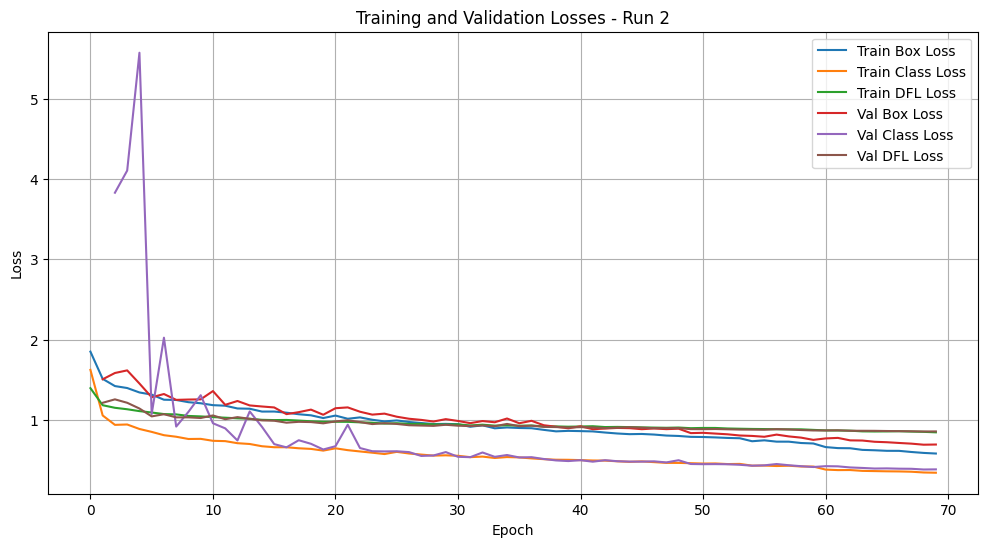

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training results from the CSV file
results_path = '/kaggle/working/srip_training/yolov11l/run2/results.csv'
results_df = pd.read_csv(results_path)

# Strip any whitespace from column names (common issue with Ultralytics CSV files)
results_df.columns = results_df.columns.str.strip()

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(results_df['train/box_loss'], label='Train Box Loss')
plt.plot(results_df['train/cls_loss'], label='Train Class Loss')
plt.plot(results_df['train/dfl_loss'], label='Train DFL Loss')  # Distribution Focal Loss (if available)
plt.plot(results_df['val/box_loss'], label='Val Box Loss')
plt.plot(results_df['val/cls_loss'], label='Val Class Loss')
plt.plot(results_df['val/dfl_loss'], label='Val DFL Loss')      # If available
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses - Run 2')
plt.legend()
plt.grid(True)
plt.show()

####  model 3

In [24]:
model_run3 = YOLO('yolo11l.pt')
results_run3 = model_run3.train(
    data='/kaggle/working/srip_dataset_split/data.yaml',
    epochs=50,
    imgsz=416,
    batch=8,
    lr0=0.02,
    project='/kaggle/working/srip_training/yolov11l',
    name='run3'
)

Ultralytics 8.3.81 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/kaggle/working/srip_dataset_split/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=/kaggle/working/srip_training/yolov11l, name=run3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=F

train: Scanning /kaggle/working/srip_dataset_split/train/labels.cache... 1829 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1829/1829 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/srip_dataset_split/val/labels.cache... 204 images, 0 backgrounds, 0 corrupt: 100%|██████████| 204/204 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/srip_training/yolov11l/run3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.02' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to /kaggle/working/srip_training/yolov11l/run3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.83G      1.719      1.376      1.289         28        416: 100%|██████████| 229/229 [00:50<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.97it/s]

                   all        204       2098      0.238      0.428      0.233      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.56G      1.565      1.104      1.218         97        416: 100%|██████████| 229/229 [00:46<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.13it/s]

                   all        204       2098      0.728      0.595      0.687      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.62G      1.524      1.071      1.193         47        416: 100%|██████████| 229/229 [00:45<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.14it/s]

                   all        204       2098      0.536      0.557      0.549      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.64G      1.476      1.019      1.172         69        416: 100%|██████████| 229/229 [00:44<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.10it/s]

                   all        204       2098      0.632      0.619      0.604       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.62G      1.405     0.9704       1.14        110        416: 100%|██████████| 229/229 [00:45<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.23it/s]

                   all        204       2098      0.779      0.745      0.802      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.57G      1.363     0.9012       1.12         73        416: 100%|██████████| 229/229 [00:44<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.27it/s]

                   all        204       2098      0.736      0.735      0.766      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.63G      1.324      0.884      1.105         75        416: 100%|██████████| 229/229 [00:45<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.18it/s]

                   all        204       2098      0.776      0.712      0.792      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.64G      1.273      0.855      1.076         98        416: 100%|██████████| 229/229 [00:45<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.28it/s]

                   all        204       2098      0.828      0.785      0.854      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.63G      1.271     0.8041      1.071         26        416: 100%|██████████| 229/229 [00:45<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.26it/s]

                   all        204       2098      0.826      0.779      0.848      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.57G       1.24      0.779       1.06         88        416: 100%|██████████| 229/229 [00:45<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.36it/s]

                   all        204       2098      0.816      0.758      0.813      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.63G      1.233     0.7834      1.057         43        416: 100%|██████████| 229/229 [00:45<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.34it/s]

                   all        204       2098      0.785      0.734      0.788      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.63G      1.199      0.759      1.042        125        416: 100%|██████████| 229/229 [00:45<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.19it/s]

                   all        204       2098      0.859      0.841      0.895      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.67G      1.182     0.7414      1.043         76        416: 100%|██████████| 229/229 [00:45<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.22it/s]

                   all        204       2098      0.848      0.832      0.893       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.59G      1.168     0.7265      1.027         62        416: 100%|██████████| 229/229 [00:45<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.30it/s]

                   all        204       2098      0.857      0.775      0.843      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.64G      1.158     0.7058      1.024        139        416: 100%|██████████| 229/229 [00:45<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.28it/s]

                   all        204       2098       0.89      0.808      0.902      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       3.6G      1.129      0.704      1.007        118        416: 100%|██████████| 229/229 [00:45<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.19it/s]

                   all        204       2098      0.859      0.798      0.877      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.64G      1.132     0.7075      1.009        156        416: 100%|██████████| 229/229 [00:45<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.34it/s]

                   all        204       2098       0.87      0.826      0.901      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.57G      1.105      0.678      1.008        116        416: 100%|██████████| 229/229 [00:45<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.37it/s]

                   all        204       2098      0.884      0.829      0.902       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.62G      1.109     0.6725     0.9994        141        416: 100%|██████████| 229/229 [00:44<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.34it/s]

                   all        204       2098      0.874      0.833      0.905      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.63G      1.092     0.6637     0.9936         50        416: 100%|██████████| 229/229 [00:45<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.36it/s]

                   all        204       2098      0.892      0.854      0.921      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.63G      1.075     0.6563     0.9878         42        416: 100%|██████████| 229/229 [00:45<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]

                   all        204       2098      0.878      0.842      0.909      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.58G      1.058      0.639     0.9904         48        416: 100%|██████████| 229/229 [00:45<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.28it/s]

                   all        204       2098      0.878      0.864      0.915      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.61G      1.061     0.6439     0.9889         68        416: 100%|██████████| 229/229 [00:45<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.39it/s]

                   all        204       2098        0.9      0.879      0.926      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.66G      1.048     0.6214     0.9814        152        416: 100%|██████████| 229/229 [00:45<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.39it/s]

                   all        204       2098      0.908      0.857      0.927      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.61G      1.043     0.6263     0.9776         95        416: 100%|██████████| 229/229 [00:45<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.35it/s]

                   all        204       2098      0.891      0.847      0.917       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.58G      1.023     0.6102     0.9718         49        416: 100%|██████████| 229/229 [00:44<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.37it/s]

                   all        204       2098      0.897      0.867      0.932      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.64G      1.016     0.6104     0.9664        135        416: 100%|██████████| 229/229 [00:45<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.39it/s]

                   all        204       2098       0.92      0.847      0.931      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.63G      1.009     0.6065     0.9647         69        416: 100%|██████████| 229/229 [00:45<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.39it/s]

                   all        204       2098      0.904      0.875       0.93      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.64G      1.008     0.6016     0.9669         37        416: 100%|██████████| 229/229 [00:45<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.41it/s]

                   all        204       2098      0.917      0.885      0.942      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.64G      1.006     0.5932     0.9612        135        416: 100%|██████████| 229/229 [00:44<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.22it/s]

                   all        204       2098      0.903      0.892      0.944       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.64G     0.9764     0.5742     0.9565         29        416: 100%|██████████| 229/229 [00:44<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.41it/s]

                   all        204       2098      0.919      0.897      0.947      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.64G      0.968     0.5681      0.953         96        416: 100%|██████████| 229/229 [00:45<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.33it/s]

                   all        204       2098      0.899        0.9      0.946      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       3.6G     0.9586     0.5689     0.9534        143        416: 100%|██████████| 229/229 [00:45<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.35it/s]

                   all        204       2098      0.925      0.893      0.949        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.59G     0.9613     0.5612      0.951         73        416: 100%|██████████| 229/229 [00:45<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        204       2098      0.897      0.881      0.932      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.63G     0.9154      0.534     0.9303         79        416: 100%|██████████| 229/229 [00:45<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        204       2098      0.931        0.9      0.954      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.63G      0.934     0.5434     0.9393         94        416: 100%|██████████| 229/229 [00:45<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.34it/s]

                   all        204       2098      0.915      0.906      0.947      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.62G     0.9191     0.5375     0.9366         82        416: 100%|██████████| 229/229 [00:45<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        204       2098      0.924      0.898      0.954      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.58G     0.9067     0.5233     0.9278         87        416: 100%|██████████| 229/229 [00:45<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.45it/s]

                   all        204       2098      0.932      0.895      0.961      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.63G     0.8819     0.5128     0.9243         91        416: 100%|██████████| 229/229 [00:44<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]

                   all        204       2098      0.932      0.904      0.959      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.62G     0.8704     0.5009     0.9184         33        416: 100%|██████████| 229/229 [00:45<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.41it/s]

                   all        204       2098      0.931       0.92      0.958      0.727


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.64G     0.8381     0.4731      0.918         47        416: 100%|██████████| 229/229 [00:45<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.33it/s]

                   all        204       2098      0.929      0.905      0.961      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.61G     0.8432     0.4745     0.9142         19        416: 100%|██████████| 229/229 [00:45<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        204       2098      0.926      0.923      0.962      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.63G     0.8148     0.4671     0.9106         69        416: 100%|██████████| 229/229 [00:45<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.33it/s]

                   all        204       2098      0.931      0.916      0.962      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.61G     0.7888     0.4459     0.9007         78        416: 100%|██████████| 229/229 [00:45<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        204       2098      0.928      0.924      0.962      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.62G     0.7969     0.4449     0.9032         59        416: 100%|██████████| 229/229 [00:45<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]

                   all        204       2098      0.949      0.916      0.962      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.57G     0.7755     0.4367     0.8954        111        416: 100%|██████████| 229/229 [00:44<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.41it/s]

                   all        204       2098      0.949      0.913      0.964      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.62G     0.7707     0.4334     0.8909         50        416: 100%|██████████| 229/229 [00:45<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.30it/s]

                   all        204       2098      0.951      0.918      0.966      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.62G     0.7505     0.4184     0.8917         57        416: 100%|██████████| 229/229 [00:45<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.36it/s]

                   all        204       2098      0.944      0.923      0.968      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.66G     0.7474     0.4243     0.8808         56        416: 100%|██████████| 229/229 [00:44<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.44it/s]

                   all        204       2098      0.947      0.927      0.968      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.59G     0.7392     0.4163     0.8829         97        416: 100%|██████████| 229/229 [00:44<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]

                   all        204       2098      0.948      0.922      0.968      0.767



50 epochs completed in 0.683 hours.
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run3/weights/last.pt, 51.2MB
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run3/weights/best.pt, 51.2MB

Validating /kaggle/working/srip_training/yolov11l/run3/weights/best.pt...
Ultralytics 8.3.81 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]


                   all        204       2098      0.949      0.921      0.968      0.767


Speed: 0.1ms preprocess, 5.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/srip_training/yolov11l/run3


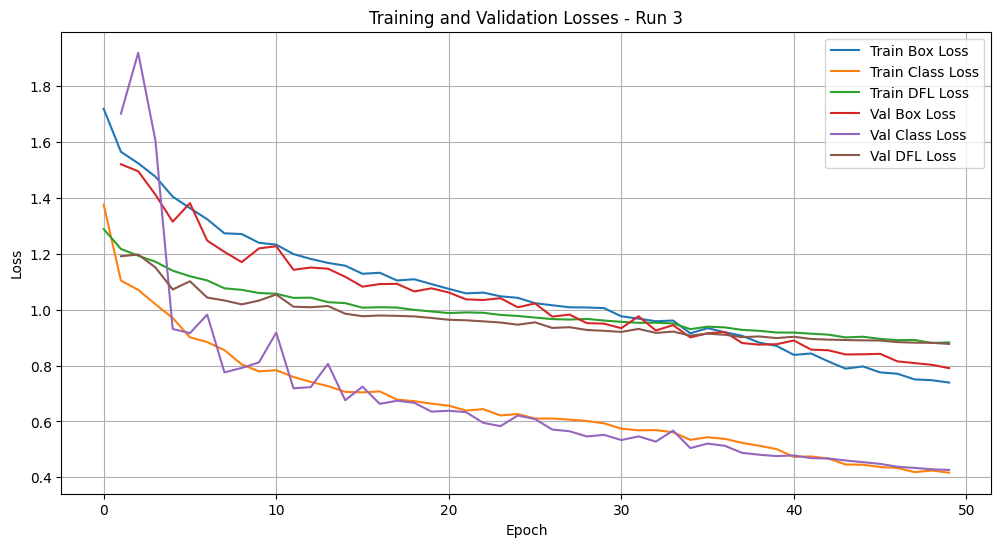

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training results from the CSV file
results_path = '/kaggle/working/srip_training/yolov11l/run3/results.csv'
results_df = pd.read_csv(results_path)

# Strip any whitespace from column names (common issue with Ultralytics CSV files)
results_df.columns = results_df.columns.str.strip()

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(results_df['train/box_loss'], label='Train Box Loss')
plt.plot(results_df['train/cls_loss'], label='Train Class Loss')
plt.plot(results_df['train/dfl_loss'], label='Train DFL Loss')  # Distribution Focal Loss (if available)
plt.plot(results_df['val/box_loss'], label='Val Box Loss')
plt.plot(results_df['val/cls_loss'], label='Val Class Loss')
plt.plot(results_df['val/dfl_loss'], label='Val DFL Loss')      # If available
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses - Run 3')
plt.legend()
plt.grid(True)
plt.show()

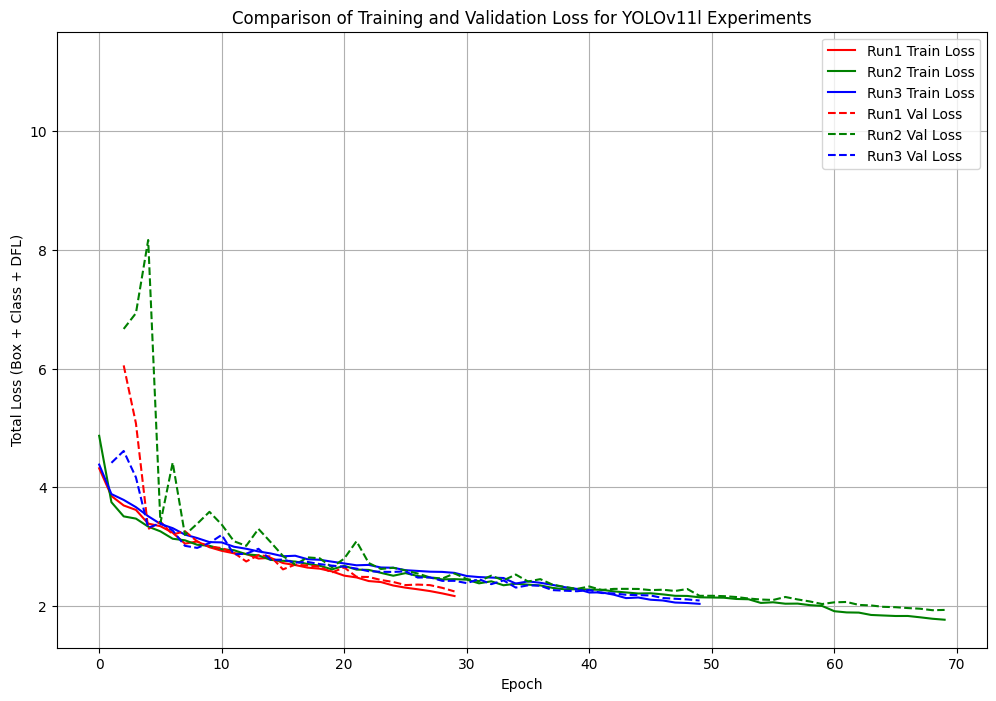

In [26]:
results_path1 = '/kaggle/working/srip_training/yolov11l/run1/results.csv'  # From your previous run1
results_path2 = '/kaggle/working/srip_training/yolov11l/run2/results.csv'
results_path3 = '/kaggle/working/srip_training/yolov11l/run3/results.csv'

history1 = pd.read_csv(results_path1)
history2 = pd.read_csv(results_path2)
history3 = pd.read_csv(results_path3)

# Strip whitespace from column names
history1.columns = history1.columns.str.strip()
history2.columns = history2.columns.str.strip()
history3.columns = history3.columns.str.strip()

# --- Create a combined plot ---
plt.figure(figsize=(12, 8))

# Plot training loss curves (solid lines)
plt.plot(history1['train/box_loss'] + history1['train/cls_loss'] + history1['train/dfl_loss'], 
         label='Run1 Train Loss', color='red')
plt.plot(history2['train/box_loss'] + history2['train/cls_loss'] + history2['train/dfl_loss'], 
         label='Run2 Train Loss', color='green')
plt.plot(history3['train/box_loss'] + history3['train/cls_loss'] + history3['train/dfl_loss'], 
         label='Run3 Train Loss', color='blue')

# Plot validation loss curves (dashed lines)
plt.plot(history1['val/box_loss'] + history1['val/cls_loss'] + history1['val/dfl_loss'], 
         label='Run1 Val Loss', color='red', linestyle='dashed')
plt.plot(history2['val/box_loss'] + history2['val/cls_loss'] + history2['val/dfl_loss'], 
         label='Run2 Val Loss', color='green', linestyle='dashed')
plt.plot(history3['val/box_loss'] + history3['val/cls_loss'] + history3['val/dfl_loss'], 
         label='Run3 Val Loss', color='blue', linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Total Loss (Box + Class + DFL)')
plt.title('Comparison of Training and Validation Loss for YOLOv11l Experiments')
plt.legend()
plt.grid(True)
plt.show()

#### 2.Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels. 


image 1/1 /kaggle/working/srip_dataset_split/test/images/solarpanels_native_1__x0_670_y0_8588_dxdy_416.tif: 416x416 9 solar_panels, 28.0ms
Speed: 0.9ms preprocess, 28.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/working/srip_dataset_split/test/images/solarpanels_native_2__x0_5781_y0_5282_dxdy_416.tif: 416x416 12 solar_panels, 28.0ms
Speed: 0.8ms preprocess, 28.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/working/srip_dataset_split/test/images/solarpanels_native_2__x0_5619_y0_6600_dxdy_416.tif: 416x416 6 solar_panels, 27.6ms
Speed: 0.7ms preprocess, 27.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/working/srip_dataset_split/test/images/solarpanels_native_3__x0_10564_y0_10524_dxdy_416.tif: 416x416 7 solar_panels, 27.4ms
Speed: 0.7ms preprocess, 27.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/working/srip_dataset_split/

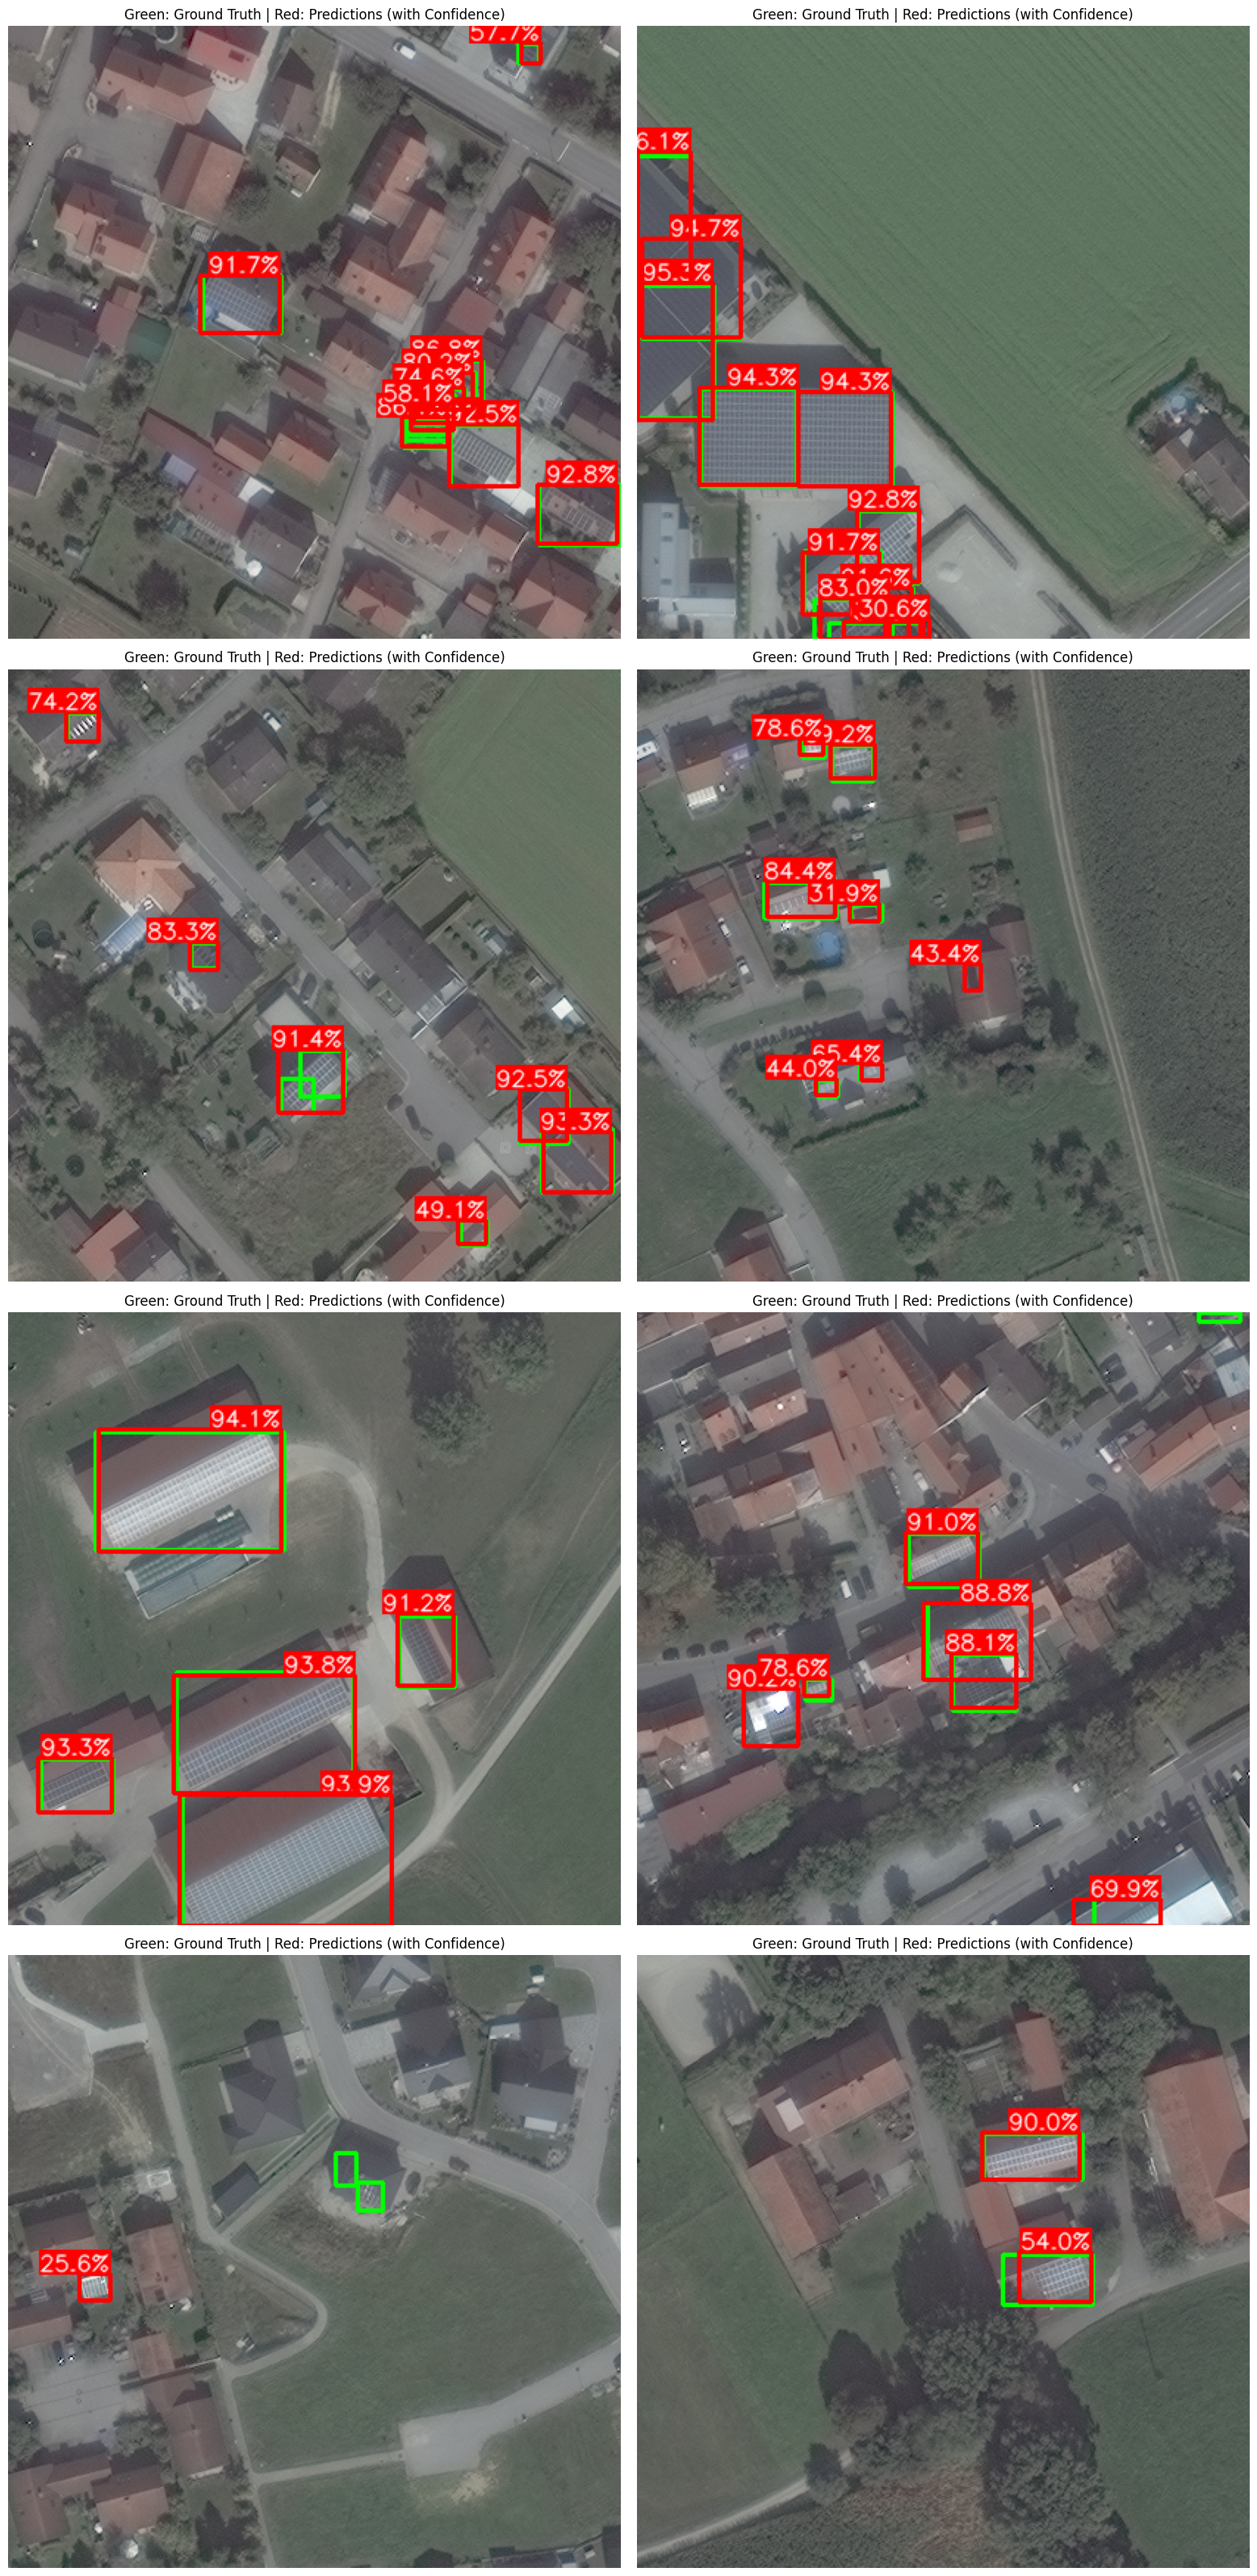

In [27]:
import os
import cv2
import glob
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO

def load_gt_boxes(label_path, img_width=416, img_height=416):
    """
    Load ground truth boxes from a YOLO-format label file and convert 
    them to absolute pixel coordinates [x_min, y_min, x_max, y_max].
    
    Each line in the label file has:
        class, x_center, y_center, width, height  (all normalized)
    
    Args:
        label_path (str): Path to the label file.
        img_width (int): Image width in pixels.
        img_height (int): Image height in pixels.
    
    Returns:
        list: A list of bounding boxes in absolute coordinates.
    """
    boxes = []
    if not os.path.exists(label_path):
        return boxes
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            # Convert the normalized values to absolute pixel coordinates
            _, x_center, y_center, w_norm, h_norm = map(float, parts)
            x_min = int((x_center - w_norm/2) * img_width)
            y_min = int((y_center - h_norm/2) * img_height)
            x_max = int((x_center + w_norm/2) * img_width)
            y_max = int((y_center + h_norm/2) * img_height)
            boxes.append([x_min, y_min, x_max, y_max])
    return boxes

# Define paths for test images and labels
test_img_dir = '/kaggle/working/srip_dataset_split/test/images'
test_lbl_dir = '/kaggle/working/srip_dataset_split/test/labels'

# Get a list of all test images (adjust extension if needed)
test_images = glob.glob(os.path.join(test_img_dir, '*'))
# Randomly sample 8 images for visualization
sample_images = random.sample(test_images, 8)

# Path to the trained model (run2 weights)
model_path = '/kaggle/working/srip_training/yolov11l/run2/weights/last.pt'
# Load the trained model
model = YOLO(model_path)

# Create a 4x2 subplot grid
fig, axes = plt.subplots(4, 2, figsize=(16, 32))  # 4 rows, 2 columns, adjusted figure size
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop over the sample test images for prediction and visualization
for idx, img_path in enumerate(sample_images):
    # Load image using cv2 and convert to RGB for matplotlib
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Determine the corresponding label file (assuming images are .tif)
    base_name = os.path.basename(img_path)
    label_file = os.path.join(test_lbl_dir, base_name.replace('.tif', '.txt'))
    # Load ground truth boxes
    gt_boxes = load_gt_boxes(label_file, img_width=416, img_height=416)
    
    # Predict using the trained model
    results = model.predict(source=img_path, conf=0.25, iou=0.5)
    pred_boxes = []
    pred_scores = []
    
    if results:
        # Assuming results[0] contains the predictions for the image
        for box in results[0].boxes.xyxy.cpu().numpy():
            pred_boxes.append(box.tolist())
        for score in results[0].boxes.conf.cpu().numpy():
            pred_scores.append(score)
    
    # Draw ground truth boxes (green) on the image
    for box in gt_boxes:
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    # Draw predicted boxes (red) along with confidence scores on the image
    for box, score in zip(pred_boxes, pred_scores):
        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        text = f"{score*100:.1f}%"
        # Calculate text size to position the score at the top-right corner of the box
        ((text_width, text_height), _) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        # Draw a filled rectangle for better text visibility
        cv2.rectangle(img_rgb, (x_max - text_width, y_min), (x_max, y_min - text_height - 4), (255, 0, 0), -1)
        cv2.putText(img_rgb, text, (x_max - text_width, y_min - 2), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    
    # Display the image with boxes in the corresponding subplot
    axes[idx].imshow(img_rgb)
    axes[idx].set_title("Green: Ground Truth | Red: Predictions (with Confidence)")
    axes[idx].axis("off")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#### 3.Use supervision.metrics functionality from supervision library to compute the following metrics.


a.Compute mAP50 with supervision and compare with your implementation. What do you observe 

In [28]:
from tqdm import tqdm
from ultralytics import YOLO
from supervision import ConfusionMatrix

In [29]:
import os
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from supervision import mAP, ConfusionMatrix

# -------------------------------
# Helper: Load ground truth boxes
# -------------------------------

#Load ground truth boxes from a YOLO-format label file and convert them to absolute pixel coordinates [x_min, y_min, x_max, y_max].
def load_gt_boxes(label_path, img_width=416, img_height=416):

    boxes = []
    if not os.path.exists(label_path):
        return boxes
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            # YOLO format: class, x_center, y_center, width, height (all normalized)
            _, x_center, y_center, w_norm, h_norm = map(float, parts)
            x_min = int((x_center - w_norm/2) * img_width)
            y_min = int((y_center - h_norm/2) * img_height)
            x_max = int((x_center + w_norm/2) * img_width)
            y_max = int((y_center + h_norm/2) * img_height)
            boxes.append([x_min, y_min, x_max, y_max])
    return boxes

# -------------------------------
# Paths and Model Setup
# -------------------------------
test_img_dir = '/kaggle/working/srip_dataset_split/test/images'
test_lbl_dir = '/kaggle/working/srip_dataset_split/test/labels'
test_images = glob.glob(os.path.join(test_img_dir, '*'))

# Load the trained model (using run2 weights as an example)
model_path = '/kaggle/working/srip_training/yolov11l/run2/weights/best.pt'
model = YOLO(model_path)

# -------------------------------
# 1. Compute mAP50 using supervision
# -------------------------------
all_gt = []
all_pred = []

for img_path in tqdm(test_images, desc="Computing mAP50 on Test Set"):
    base_name = os.path.basename(img_path)
    label_file = os.path.join(test_lbl_dir, base_name.replace('.tif', '.txt'))
    gt_boxes = load_gt_boxes(label_file)
    for box in gt_boxes:
        all_gt.append({"image": img_path, "bbox": box, "class": 0})
    
    results = model.predict(source=img_path, conf=0.25, iou=0.5)
    for result in results:
        for box, conf in zip(result.boxes.xyxy.cpu().numpy(), result.boxes.conf.cpu().numpy()):
            all_pred.append({
                "image": img_path,
                "bbox": box.tolist(),
                "class": 0,
                "score": float(conf)
            })

map50_sup = mAP(all_pred, all_gt, iou_threshold=0.5)
print(f"Computed mAP50 using supervision: {map50_sup:.4f}")

# If you have your own mAP50 implementation, compare here:
# map50_custom = custom_map50_function(all_pred, all_gt)
# print(f"Computed mAP50 using custom implementation: {map50_custom:.4f}")
# Observation: They should be very similar if both implementations are correct.

# -------------------------------
# 2. Compute Precision, Recall, and F1 across thresholds
# -------------------------------
iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
conf_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
metrics_results = []

for iou_thresh in iou_thresholds:
    for conf_thresh in conf_thresholds:
        # Initialize ConfusionMatrix from supervision
        cm = ConfusionMatrix(class_names=['solar_panel'], 
                             iou_threshold=iou_thresh, 
                             confidence_threshold=conf_thresh)
        # Process each test image
        for img_path in test_images:
            base_name = os.path.basename(img_path)
            label_file = os.path.join(test_lbl_dir, base_name.replace('.tif', '.txt'))
            gt_boxes = load_gt_boxes(label_file)
            gt_list = [{"image": img_path, "bbox": box, "class": 0} for box in gt_boxes]
            
            # Get predictions for the current thresholds
            results = model.predict(source=img_path, conf=conf_thresh, iou=iou_thresh)
            pred_list = []
            for result in results:
                for box, conf in zip(result.boxes.xyxy.cpu().numpy(), result.boxes.conf.cpu().numpy()):
                    pred_list.append({
                        "image": img_path,
                        "bbox": box.tolist(),
                        "class": 0,
                        "score": float(conf)
                    })
            # Update the confusion matrix with predictions and ground truths for this image
            cm.process_batch(pred_list, gt_list)
        
        # Extract confusion matrix statistics
        TP = cm.TP
        FP = cm.FP
        FN = cm.FN
        precision_val = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall_val = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_val = 2 * precision_val * recall_val / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0
        
        metrics_results.append({
            "IoU Threshold": iou_thresh,
            "Confidence Threshold": conf_thresh,
            "Precision": precision_val,
            "Recall": recall_val,
            "F1": f1_val
        })

# Convert results to a DataFrame for easier visualization
df_metrics = pd.DataFrame(metrics_results)
print("\nOverall Metrics Table:")
print(df_metrics)

# Optionally, create pivot tables for each metric
pivot_precision = df_metrics.pivot(index="IoU Threshold", columns="Confidence Threshold", values="Precision")
pivot_recall    = df_metrics.pivot(index="IoU Threshold", columns="Confidence Threshold", values="Recall")
pivot_f1        = df_metrics.pivot(index="IoU Threshold", columns="Confidence Threshold", values="F1")

print("\nPivot Table for Precision:")
print(pivot_precision)
print("\nPivot Table for Recall:")
print(pivot_recall)
print("\nPivot Table for F1 Score:")
print(pivot_f1)


ImportError: cannot import name 'mAP' from 'supervision' (/usr/local/lib/python3.10/dist-packages/supervision/__init__.py)

b.Create a table of Precision, Recall and F1-scores where rows are IoU thresholds [0.1, 0.3, 0.5, 0.7, 0.9] and columns are confidence thresholds [0.1, 0.3, 0.5, 0.7, 0.9] (Hint use supervision.metrics.ConfusionMatrix to get the confusion matrix and get TP, FP and FN from it to compute the P, R and F-1) 